In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [3]:
from pathlib import Path

from tqdm import tqdm
import cv2
import numpy as np
from keras import utils
import matplotlib.pyplot as plt

from converter import Mc2RealConverter

2023-07-01 09:22:05.843511: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-01 09:22:06.098101: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 09:22:07.404666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lklimkiewicz/stud/gsn/minecraft/workspace_v2/conda/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal m

In [4]:
mc2real = Mc2RealConverter()

2023-07-01 09:22:13.709563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 09:22:13.910850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 09:22:13.911007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Quick test

In [5]:
dataset = utils.image_dataset_from_directory(
    directory='sample_images',
    image_size=(256, 256),
    labels=None,
    batch_size=1,
)

Found 10405 files belonging to 1 classes.


2023-07-01 09:22:19.867992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10405]
	 [[{{node Placeholder/_0}}]]
2023-07-01 09:22:19.868314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10405]
	 [[{{node Placeholder/_0}}]]


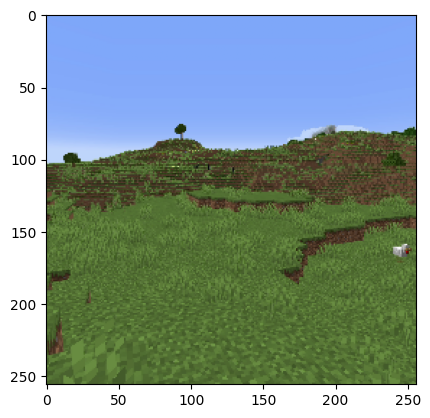

In [6]:
mc_image = next(iter(dataset))[0].numpy() / 255
plt.imshow(mc_image)

2023-07-01 09:22:33.177939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-01 09:22:35.649631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-01 09:22:35.698995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1,256,256,25]
	 [[{{node Placeholder/_1}}]]
  0%|          | 0/100 [00:00<?, ?it/s]2023-07-01 09:22:40.372125: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x8c7926f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-01 09:22:40.372155: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForc

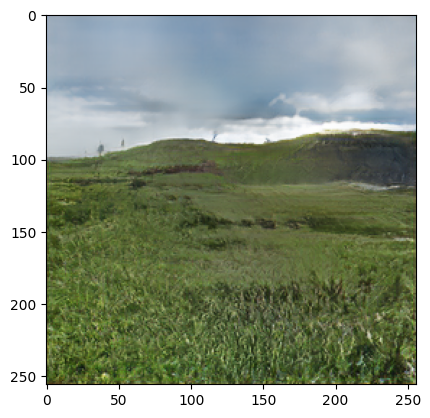

In [7]:
%autoreload
real_image = mc2real(mc_image, opt_steps=100)
plt.imshow(real_image)

hello float32 0.96862745


0it [00:00, ?it/s]
2023-07-01 00:48:40.870855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1,256,256,25]
	 [[{{node Placeholder/_1}}]]


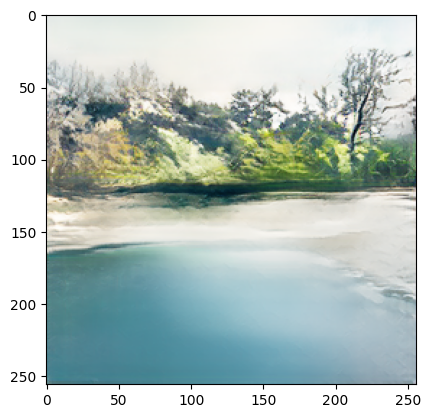

In [30]:
%autoreload
real_image = mc2real(mc_image, opt_steps=0)
plt.imshow(real_image)

## Convert whole dataset

In [48]:
input_dataset = utils.image_dataset_from_directory(
    directory='dataset/minecraft',
    image_size=(256, 256),
    labels=None,
    batch_size=None,
)

Found 10405 files belonging to 1 classes.


In [70]:
def convert_single_image(root_path, idx, mc_image):
    mc_image = mc_image.numpy().astype(np.float32) / 255
    
    real_image = mc2real(mc_image).astype(np.float32) / 255
    joined_image = np.concatenate([mc_image, real_image], axis=1)
    
    mc_path = root_path / 'minecraft' / f'{idx:05}.png'
    real_path = root_path / 'real' / f'{idx:05}.png'
    joined_path = root_path / 'joined' / f'{idx:05}.png'
    
    cv2.imwrite(str(mc_path), mc_image[..., ::-1]*255)
    cv2.imwrite(str(real_path), real_image[..., ::-1]*255)
    cv2.imwrite(str(joined_path), joined_image[..., ::-1]*255)

In [72]:
def convert_dataset(root_path):
    for idx, mc_image in tqdm(enumerate(input_dataset), total=len(input_dataset)):
        convert_single_image(root_path, idx, mc_image)

In [ ]:
convert_dataset(Path('dataset_mc_real'))

## Calculating FID

In [3]:
from cleanfid import fid

In [5]:
fid_score = fid.compute_fid(
    'dataset_mc_real/real',
    'dataset_real',
    mode='clean'
)

compute FID between two folders
Found 10405 images in the folder dataset_mc_real/real


FID real : 100%|██████████| 326/326 [00:25<00:00, 12.59it/s]


Found 90000 images in the folder dataset_real


FID dataset_real : 100%|██████████| 2813/2813 [03:40<00:00, 12.75it/s]


In [8]:
print(f'Fid is {fid_score:.2f}')

Fid is 44.22
